In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.optim import SGD
import torch.nn.functional as F

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
train_dataset = CIFAR10(root=".", download=True, train=True, transform=ToTensor())
test_dataset = CIFAR10(root=".", download=True, train=False, transform=ToTensor())
len(train_dataset), len(test_dataset)

100%|██████████| 170498071/170498071 [00:05<00:00, 31195321.60it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [5]:
train_dataset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

Text(0.5, 1.0, '2')

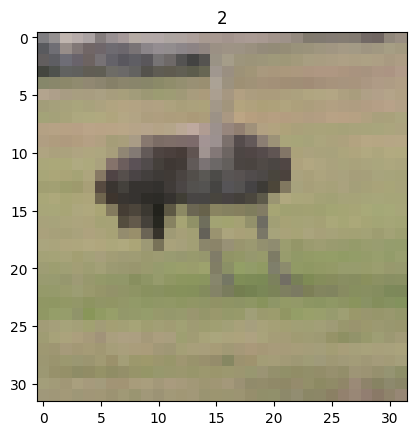

In [6]:
image, label = train_dataset[42]
plt.imshow(torch.permute(image, (1,2,0)))
plt.title(label)


In [7]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=64)

In [8]:
class CNNModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Flatten(),
        nn.Linear(128 * 4 * 4, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
        )
  def forward(self, X):
    return self.model(X)

In [12]:
EPOCHS = 30

model = CNNModel()
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01)

losses = []

for _ in range(EPOCHS):

  model.train()
  mini_train_loss = []
  for x_train_batch, y_train_batch in train_loader:
    x_train_batch = x_train_batch.to(device)
    y_train_batch = y_train_batch.to(device)
    y_pred = model(x_train_batch)
    loss = loss_fn(y_pred, y_train_batch)
    mini_train_loss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  avg_loss = np.mean(mini_train_loss)
  print(avg_loss)
  losses.append(avg_loss)


1.6322760124645574
1.1655258005842224
0.9804050349213583
0.8707032476544685
0.7882901101999575
0.7192541339132182
0.6653530232589263
0.6123356272268783
0.5635561325284831
0.5274839910590435
0.486841877136389
0.4404176280778997
0.4097346730930421
0.3762121333566773
0.338995353197274
0.3115158686152352
0.27859337056231925
0.25252486280906383
0.22934490885309247
0.19909991097667484
0.1745995598585557
0.1552384941102675
0.13712139945963156
0.12173053927605262
0.09049363667859942
0.0805629873219544
0.08526528710285035
0.06834486201572258
0.06540698619545116
0.050911441163095594


In [13]:
model.eval()  # Set model to evaluation mode
mode = model.to("cpu")
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        # images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the CNN model on the test set: {accuracy:.2f}%')

Accuracy of the CNN model on the test set: 75.33%
